# Simulate a Discrete-Time Dynamic System

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from platform import python_version
print(f"Python: {python_version()}")
print(f"Jax: {jax.__version__}")

Python: 3.11.7
Jax: 0.4.23


## Example 1. First order auto-regressive model - AR(1)

In [2]:
def sys(yk, uk, params):
    a1 = params['a1']
    b0 = params['b0']
    return a1 * yk + b0 * uk

In [3]:
nT = 10
Ts = 1
t = Ts * jnp.arange(nT+1)
U = np.zeros((nT+1, 1), dtype='float32')
U[t >= 1, :] = 1.
U = jnp.array(U)

In [4]:
y0 = jnp.zeros(1, dtype='float32')
params = {
    'a1': 0.5,
    'b0': 0.5
}

In [5]:
# Simulate with Python for-loop
Y = []
yk = y0.copy()
for k in range(nT+1):
    Y.append(yk)
    uk = U[k, :]
    yk = sys(yk, uk, params)
Y = jnp.array(Y)

index = pd.Index(t, name='t')
sim_result = pd.concat(
    [pd.DataFrame(X, index=index) for X in [U, Y]],
    axis=1,
    keys=['U', 'Y']
)
sim_result.head()

,U,Y
,0,0
t,,
0,0.0,0.000
1,1.0,0.000
2,1.0,0.500
3,1.0,0.750
4,1.0,0.875


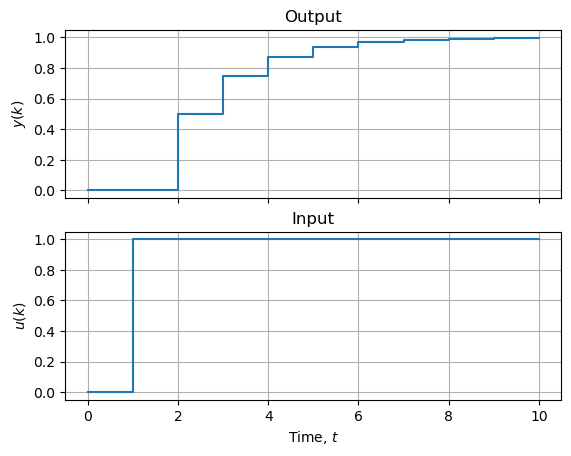

In [6]:
fig, axes = plt.subplots(2, 1, sharex=True)

ax = axes[0]
ax.step(t, Y, where='post')
ax.set_ylabel('$y(k)$')
ax.set_title('Output')
ax.grid()

ax = axes[1]
ax.step(t, U, where='post')
ax.set_ylabel('$u(k)$')
ax.set_xlabel('Time, $t$')
ax.set_title('Input')
ax.grid()

plt.show()

In [7]:
# Simulate using jax.scan
update = lambda yk, uk: (sys(yk, uk, params), yk)
_, Y = jax.lax.scan(update, y0, U)

sim_result_jax = pd.concat(
    [pd.DataFrame(X, index=index) for X in [U, Y]],
    axis=1,
    keys=['U', 'Y']
)
sim_result_jax.head()

,U,Y
,0,0
t,,
0,0.0,0.000
1,1.0,0.000
2,1.0,0.500
3,1.0,0.750
4,1.0,0.875


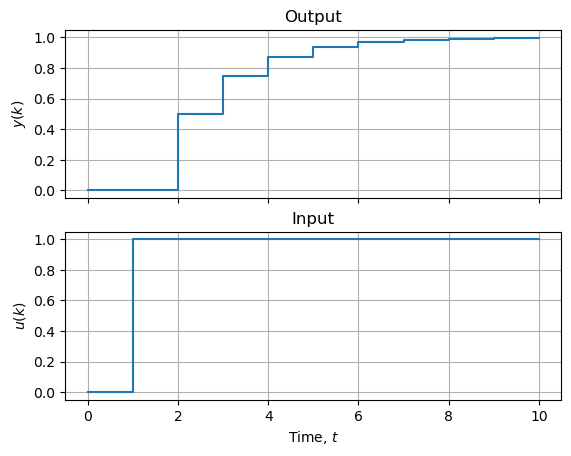

In [8]:
fig, axes = plt.subplots(2, 1, sharex=True)

ax = axes[0]
ax.step(t, Y, where='post')
ax.set_ylabel('$y(k)$')
ax.set_title('Output')
ax.grid()

ax = axes[1]
ax.step(t, U, where='post')
ax.set_ylabel('$u(k)$')
ax.set_xlabel('Time, $t$')
ax.set_title('Input')
ax.grid()

plt.show()

## Example 2. State-Space Model

In [9]:
# Linear discrete-time state-space model
A = jnp.array([
    [ 0.9048, -0.    ,  0.    , -0.    , -0.    ],
    [ 0.    ,  0.655 , -0.131 ,  0.    ,  0.    ],
    [ 0.    ,  0.2047,  0.9825,  0.    ,  0.    ],
    [ 0.    ,  0.    ,  0.    ,  0.7788,  0.    ],
    [-0.    , -0.    , -0.    , -0.    ,  0.8668]
])
B = jnp.array([
    [ 0.2379, -0.    ],
    [ 0.4094,  0.    ],
    [ 0.0548,  0.    ],
    [ 0.    ,  0.4424],
    [-0.    ,  0.4659]
])
C = jnp.array([
    [0.4   , 0.    , 0.    , 0.375 , 0.    ],
    [0.    , 0.    , 0.32  , 0.    , 0.7143]
])

def f(x, u):
    return A.dot(x) + B.dot(u)

def g(x, u):
    return C.dot(x)

def update(x, u):
    y = g(x, u)
    x = f(x, u)
    return x, y

x0 = jnp.zeros(5)

# Inputs
U = jnp.zeros((50, 2)).at[10:].set([1, 0]).at[30:].set([1, -1])

# Simulate
xN, Y = jax.lax.scan(update, x0, U)

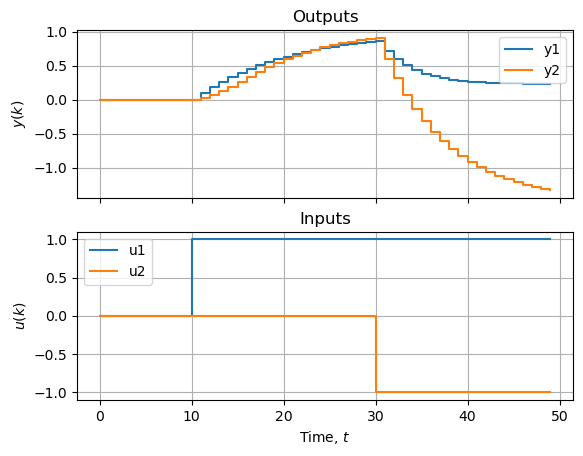

In [10]:
fig, axes = plt.subplots(2, 1, sharex=True)

t = np.arange(50).reshape(-1, 1)

ax = axes[0]
ax.step(t, Y, where='post', label=['y1', 'y2'])
ax.set_ylabel('$y(k)$')
ax.set_title('Outputs')
ax.grid()
ax.legend()

ax = axes[1]
ax.step(t, U, where='post', label=['u1', 'u2'])
ax.set_ylabel('$u(k)$')
ax.set_xlabel('Time, $t$')
ax.set_title('Inputs')
ax.grid()
ax.legend()

plt.show()

## Example 3. Compare Numpy and Jax

In [11]:
# Linear state-space model
A = np.array([
    [ 0.9048, -0.    ,  0.    , -0.    , -0.    ],
    [ 0.    ,  0.655 , -0.131 ,  0.    ,  0.    ],
    [ 0.    ,  0.2047,  0.9825,  0.    ,  0.    ],
    [ 0.    ,  0.    ,  0.    ,  0.7788,  0.    ],
    [-0.    , -0.    , -0.    , -0.    ,  0.8668]
])
B = np.array([
    [ 0.2379, -0.    ],
    [ 0.4094,  0.    ],
    [ 0.0548,  0.    ],
    [ 0.    ,  0.4424],
    [-0.    ,  0.4659]
])
C = np.array([
    [0.4   , 0.    , 0.    , 0.375 , 0.    ],
    [0.    , 0.    , 0.32  , 0.    , 0.7143]
])

def update(x, u):
    y = C.dot(x)
    x = A.dot(x) + B.dot(u)
    return x, y

In [12]:
# Initial state
x0 = np.zeros(5)

# Inputs
nT = 99
U = np.zeros((nT+1, 2))
U[1:] = [1, 0]
U[21:] = [1, 0.5]
U[41:] = [-1, 0.5]
U[61:] = [-1, 1]

# Repeat 10 times
U = np.tile(U, (10, 1))
nT = U.shape[0] - 1
U.shape

(1000, 2)

In [13]:
%%time

# Simulate with Python for-loop
X = []
Y = []
xk = x0
u0 = U[0, :]
y0 = g(x0, u0)
yk = y0.copy()
for k in range(nT+1):
    X.append(xk)
    uk = U[k, :]
    xk, yk = update(xk, uk)
    Y.append(yk)
X = np.array(X)
Y = np.array(Y)
xf_test = xk.copy()
X_test = X.copy()
Y_test = Y.copy()

CPU times: user 6.91 ms, sys: 2.21 ms, total: 9.12 ms
Wall time: 8.11 ms


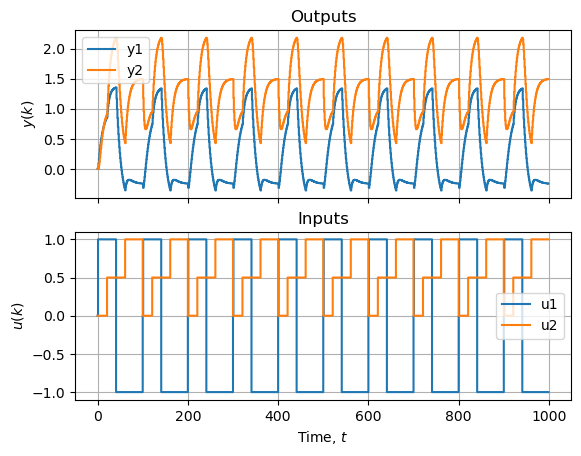

In [14]:
fig, axes = plt.subplots(2, 1, sharex=True)

t = np.arange(nT+1).reshape(-1, 1)

ax = axes[0]
ax.step(t, Y, where='post', label=['y1', 'y2'])
ax.set_ylabel('$y(k)$')
ax.set_title('Outputs')
ax.grid()
ax.legend()

ax = axes[1]
ax.step(t, U, where='post', label=['u1', 'u2'])
ax.set_ylabel('$u(k)$')
ax.set_xlabel('Time, $t$')
ax.set_title('Inputs')
ax.grid()
ax.legend()

plt.show()

In [15]:
# Jax version

# Linear state-space model
A = jnp.array(A)
B = jnp.array(B)
C = jnp.array(C)

def update(x, u):
    y = C.dot(x)
    x = A.dot(x) + B.dot(u)
    return x, y

In [16]:
%%time

# Simulate
xf, Y = jax.lax.scan(update, x0, U)

CPU times: user 81.2 ms, sys: 6 ms, total: 87.2 ms
Wall time: 131 ms


In [17]:
%%time

# Simulate again
xf, Y = jax.lax.scan(update, x0, U)

CPU times: user 981 µs, sys: 83 µs, total: 1.06 ms
Wall time: 1.1 ms


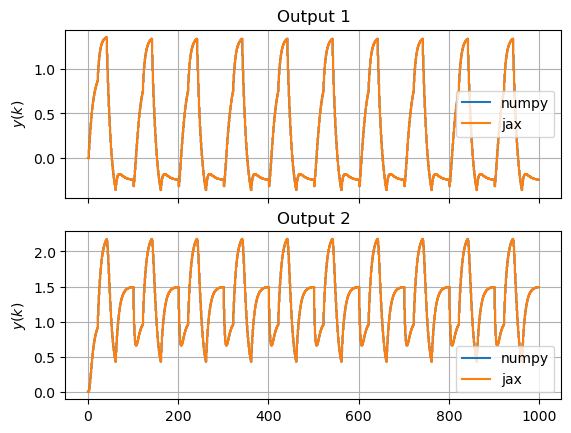

In [18]:
fig, axes = plt.subplots(2, 1, sharex=True)

t = np.arange(nT+1).reshape(-1, 1)

for i, ax in enumerate(axes):
    ax.step(t, Y_test[:, i], where='post', label='numpy')
    ax.step(t, Y[:, i], where='post', label='jax')
    ax.set_ylabel('$y(k)$')
    ax.set_title(f'Output {i+1}')
    ax.grid()
    ax.legend()

plt.show()

assert np.allclose(xf, xf_test, atol=1e-6)  # note: jax is float32 precision by default
assert np.allclose(Y, Y_test, atol=1e-6)

## Simulate Multiple Trajectories in Parallel

In [19]:
n_traj = 10

# Initial states for all simulations
x0_p = np.stack([x0] * n_traj)

# Inputs for all simulations
U_p = np.stack([U] * n_traj)
nT = U.shape[0] - 1
x0_p.shape, U_p.shape

((10, 5), (10, 1000, 2))

In [20]:
# Simulation function for one trajectory
def scan_func(x0, U):
    return jax.lax.scan(update, x0, U)

In [21]:
x0_p = jnp.stack([x0] * 5)
U_p = jnp.stack([U] * 5)

scan_parallel = jax.vmap(scan_func)
xf_p, Y_p = scan_parallel(x0_p, U_p)
xf_p.shape, Y_p.shape

((5, 5), (5, 1000, 2))

In [22]:
for i in range(n_traj):
    assert np.allclose(xf_p[i], xf_test, atol=1e-6)  # note: jax is float32 precision by default
    assert np.allclose(Y_p[i], Y_test, atol=1e-6)

In [23]:
%%time

xf_p, Y_p = scan_parallel(x0_p, U_p)

CPU times: user 6.2 ms, sys: 1.33 ms, total: 7.53 ms
Wall time: 6.33 ms
